# AF Lep 4S - Fake Planets

## 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from scipy.ndimage import gaussian_filter

# Plotting
import cmocean
import matplotlib.pylab as plt
color_map = cmocean.cm.ice
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

# Methods
from fours.models.psf_subtraction import FourS
from fours.utils.pca import pca_psf_subtraction_gpu
from fours.utils.data_handling import read_fours_root_dir
from fours.utils.data_handling import save_as_fits

# Pynpoint
from pynpoint.util.analysis import fake_planet

# AppleFy
from applefy.utils.file_handling import load_adi_data, open_fits
from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.photometry import AperturePhotometryMode, mag2flux_ratio, flux_ratio2mag
from applefy.statistics import TTest

## 2. Load the data

In [2]:
root_dir = Path(read_fours_root_dir())

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
dataset_file = root_dir / Path("30_data/HD35850_294_088_C-0085_A_.hdf5")
experiment_root_dir = root_dir / Path("70_results/x2_af_lep/fake_planets/")

In [4]:
experiment_root_dir.mkdir(parents=True, exist_ok=True)

In [5]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_selected",
    psf_template_tag="psf_selected",
    para_tag="header_object_selected/PARANG")

science_data = science_data[:, 25:-25, 25:-25]

In [6]:
fwhm = 3.6
pixel_scale = 0.0271

### 2.1 Temporal binnging

In [7]:
binning = 5  # stack every 5 frames
angles_stacked = np.array([
    np.mean(i)
    for i in np.array_split(angles, int(len(angles) / binning))])
science_stacked = np.array([
    np.mean(i, axis=0)
    for i in np.array_split(science_data, int(len(angles) / binning))])

## 3. Remove the planet

In [8]:
# prepare the psf template
psf_template = np.median(raw_psf_template_data, axis=0)
# pad the psf template
padded_psf = np.pad(
    psf_template,
    pad_width=((46, 46), (46, 46)),
    mode='constant',
    constant_values=0)

In [9]:
separation = np.sqrt((68.5-57)**2 + (54.8 - 57)**2)
position_angle = 258.81 + 0.39  # calibration offest
magnitude = 10.03

stack_no_planet = fake_planet(
    images= science_stacked,
    psf=np.expand_dims(padded_psf, axis=0),
    parang= np.rad2deg(angles_stacked),
    position= (separation, position_angle),
    magnitude= magnitude,
    psf_scaling= -1/0.0179) # ND filter, negative planet

## 4. Run 4S on the data without the planet

In [10]:
lambda_reg = 25000

In [11]:
work_dir = experiment_root_dir / Path("4S_no_planet")
work_dir.mkdir(exist_ok=True)

In [12]:
s4_model = FourS(
    science_cube=stack_no_planet,
    adi_angles=angles_stacked,
    psf_template=psf_template,
    device=0,
    work_dir=work_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=lambda_reg,
    psf_fwhm=fwhm,
    right_reason_mask_factor=1.5)

In [13]:
s4_model.fit_noise_model(
    num_epochs=100,
    training_name="AF_Lep_" + str(lambda_reg),
    logging_interval=1)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


In [14]:
s4_mean_residual_no_planet, _ = s4_model.compute_residuals()

S4 model: computing residual ... [DONE]


## 5. Run 4S with the planet

In [15]:
work_dir = experiment_root_dir / Path("4S_with_planet")
work_dir.mkdir(exist_ok=True)

In [16]:
s4_model = FourS(
    science_cube=science_stacked,
    adi_angles=angles_stacked,
    psf_template=psf_template,
    device=0,
    work_dir=work_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=lambda_reg,
    psf_fwhm=fwhm,
    right_reason_mask_factor=1.5)

In [17]:
s4_model.fit_noise_model(
    num_epochs=100,
    training_name="AF_Lep_" + str(lambda_reg),
    logging_interval=1)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


In [18]:
s4_mean_residual_with_planet, _ = s4_model.compute_residuals()

S4 model: computing residual ... [DONE]


## 6. Add fake planets at different angles and run 4S

In [19]:
test_angles = np.linspace(0, 360, 40, endpoint=False)
sigmas = np.linspace

In [20]:
test_angles

array([  0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,
        99., 108., 117., 126., 135., 144., 153., 162., 171., 180., 189.,
       198., 207., 216., 225., 234., 243., 252., 261., 270., 279., 288.,
       297., 306., 315., 324., 333., 342., 351.])

In [ ]:
tmp_all_residuals = []
for tmp_angle in test_angles:
    # 1. Add the fake planet
    tmp_data_with_planet = fake_planet(
        images= stack_no_planet,
        psf=np.expand_dims(padded_psf, axis=0),
        parang= np.rad2deg(angles_stacked),
        position= (separation, tmp_angle),
        magnitude= magnitude,
        psf_scaling= 1/0.0179) # ND filter, positive planet

    # 2. Run 4S
    work_dir = experiment_root_dir / Path("with_planet/4S_" + str(tmp_angle))
    work_dir.mkdir(exist_ok=True, parents=True)

    s4_model = FourS(
        science_cube=tmp_data_with_planet,
        adi_angles=angles_stacked,
        psf_template=psf_template,
        device=0,
        work_dir=work_dir,
        verbose=True,
        rotation_grid_subsample=1,
        noise_model_lambda=lambda_reg,
        psf_fwhm=fwhm,
        right_reason_mask_factor=1.5)

    s4_model.fit_noise_model(
        num_epochs=100,
        training_name="4S_" + str(tmp_angle),
        logging_interval=10)

    # 3. Compute the residuals
    tmp_residual, _ = s4_model.compute_residuals()

    # 4. Store the residuals
    tmp_all_residuals.append(tmp_residual)

# 5. Store the results
fake_planet_residuals = np.array(tmp_all_residuals)
save_as_fits(
    fake_planet_residuals,
    experiment_root_dir / Path("AF_Lep_s4_fake_planet_residuals.fits"),
    overwrite=True)

## 7. Load the results

In [21]:
# load the results
fake_planet_residuals = open_fits(experiment_root_dir / Path("AF_Lep_s4_fake_planet_residuals.fits"))

## 8. Compute the S/N of the fake planets

In [22]:
# compute the 2D positions of the fake planets
# transform the polar coordinates to cartesian
center = (science_stacked.shape[1] // 2,
          science_stacked.shape[2] // 2)

positions = np.array([
    (center[0] + separation * np.sin(np.deg2rad(-angle)),
     center[1] + separation * np.cos(np.deg2rad(-angle)))
    for angle in test_angles])

In [23]:
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("ASS", search_area=0.5, psf_fwhm_radius=3.6/2)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=3.6/2)

In [24]:
# compute the S/N values for all fake planets and save them
tmp_snr_values = []

# loop over all residuals
for idx, tmp_residual in enumerate(fake_planet_residuals):
    _, _, tmp_snr = compute_detection_uncertainty(
        frame=tmp_residual,
        planet_position=positions[idx],
        statistical_test=TTest(),
        psf_fwhm_radius=fwhm,
        photometry_mode_planet=photometry_mode_planet,
        photometry_mode_noise=photometry_mode_noise,
        safety_margin=1,
        num_rot_iter=50)

    # compute the median S/N
    tmp_snr_values.append(np.mean(tmp_snr))

# store the S/N values
snr_results = np.array(tmp_snr_values)

## 9. Plot the results

In [25]:
selection = np.array([26, 10, 39])
selected_fake_planets = fake_planet_residuals[selection]
fake_planet_angles = test_angles[selection]
snr_af_lep = 6.8

In [26]:
# create a binary list for the colors if frame is in the selection
color_values = np.array([1 if idx in selection else 0 for idx in range(len(test_angles))])

In [27]:
# create a pandas Dataframe to store the results
results = pd.DataFrame(
    {
        "snr" : snr_results,
        "color" : color_values,
        "category": np.array(["A"]*len(snr_results))
    }
)

In [28]:
# set the scale for the residuals based on the residual with the planet
median= np.median(
    gaussian_filter(
        s4_mean_residual_with_planet, 
        sigma=(0.8, 0.8),
        order=0))
scale = np.max(gaussian_filter(
        s4_mean_residual_with_planet, 
        sigma=(0.8, 0.8),
        order=0))

In [29]:
def get_xy_position(angle, distance_arsec, center):
    angle_radians = np.deg2rad(angle - 90)
    distance = distance_arsec /pixel_scale

    # Calculate x and y coordinates
    x = distance * np.cos(angle_radians)
    y = distance * np.sin(angle_radians)

    return center - x, center - y

In [30]:
def plot_residual_image(
        ax_in, 
        data, 
        planet_position,
        marker_size=200,
        zoom=15):
    
    # apply the gaussian filter
    data =  gaussian_filter(
        data, 
        sigma=(0.8, 0.8),
        order=0)
    
    ax_in.imshow(
        data[zoom:-zoom, zoom:-zoom],
        cmap=color_map,
        vmin=median - scale*0.5, vmax=median + scale,
        origin="lower")

    ax_in.set_xticks([])
    ax_in.set_yticks([])
    
     # plot the center of the image
    center = int(data[zoom:-zoom, zoom:-zoom].shape[0] / 2)
    ax_in.scatter(center, center, c='w', marker='*', s=30)
    
    # plot the planet position
    if planet_position is not None:
        ax_in.scatter(
            *get_xy_position(planet_position[1], 
                                       planet_position[0],
                                       center),
            c='none',
            edgecolor="w",
            linestyle="-",
            marker='o',
            alpha=0.5, lw=1.5,
            s=marker_size)

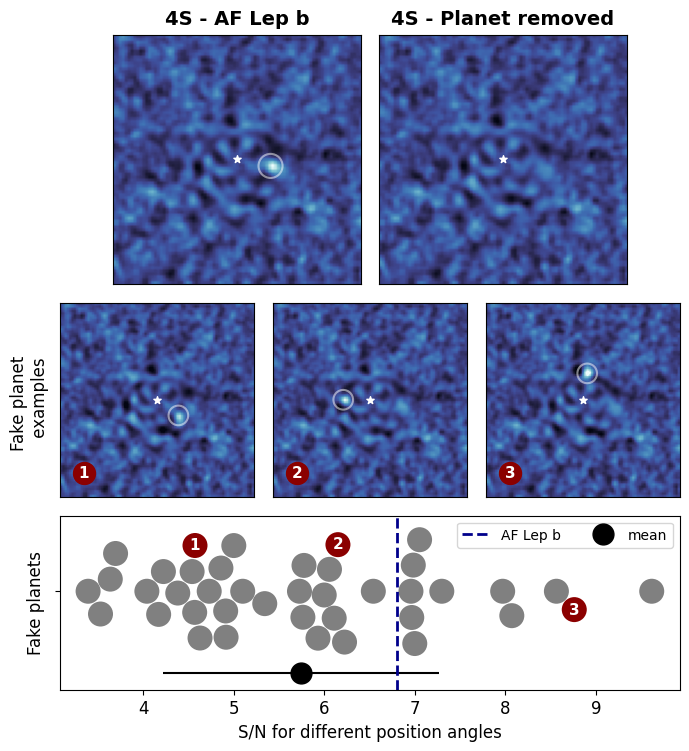

In [ ]:
# Create the Large overview plot
# The layout is a 3x2 gridspec with:
# First row: Residual with AF Lep b, Residual without AF Lep b
# Second row: 3 examples of fake planets
# Third row: S/N of the fake planets
fig = plt.figure(figsize=(8, 8.5))
gs = fig.add_gridspec(
    3, 2, 
    hspace=0.08,
    wspace=0.05,
    height_ratios=[1., 0.8, 0.7])

# First row
gs00 = gridspec.GridSpecFromSubplotSpec(
    1, 4,
    subplot_spec=gs[0, :],
    hspace=0.08, wspace=0.08,
    width_ratios=[0.6, 4, 4, 0.6])


ax1 = fig.add_subplot(gs00[0, 1])
plot_residual_image(
    ax1,
    s4_mean_residual_with_planet,
    (separation * pixel_scale, position_angle),
    marker_size=300)

ax1.set_title("4S - AF Lep b",
              y=1.01,
              fontweight="bold",
              fontsize=14)

ax2 = fig.add_subplot(gs00[0, 2])
plot_residual_image(ax2, s4_mean_residual_no_planet, None)

ax2.set_title("4S - Planet removed",
              y=1.01,
              fontweight="bold",
              fontsize=14)

# Second row
gs01 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=gs[1, :], wspace=0.1)

for idx, tmp_residual in enumerate(selected_fake_planets):
    ax = fig.add_subplot(gs01[idx])
    plot_residual_image(
        ax,
        tmp_residual,
        (separation * pixel_scale, 
         fake_planet_angles[idx]),)
    
    ax.scatter(
        [10,], [10,],
        s=250,
        color="darkred")
    
    ax.text(
        10, 10,
        str(idx + 1), 
        color="white",
        fontweight="bold",
        ha='center', va='center', fontsize=11)

    if idx == 0:
        ax.set_ylabel("Fake planet \n examples",
                      #fontweight="bold",
                      labelpad=8,
                      fontsize=12)

# Third row
ax3 = fig.add_subplot(gs[2, :])

# create a binary color palette for seaborn with gray and dark red
color_palette = sns.color_palette(["gray", "darkred"])

sns.swarmplot(
    data=results,
    hue="color",
    x="snr",
    palette=color_palette,
    #alpha=0.5,
    orient="h",
    s=18,
    zorder=0,
    ax=ax3)

# Retrieve positions of the points
positions = []
for collection in ax3.collections:
    offsets = collection.get_offsets()
    rounded_positions = np.round(offsets, decimals=10)
    positions.extend(rounded_positions)
    
positions = np.array(positions)

# scale all y axis values by 9
positions[:,1] = positions[:,1] * 4.9

# loop over all positions and add the labels with numbers
# center the labels in the middle of the points
for idx, pos in enumerate(positions):
    
    if idx in selection:
        ax3.text(
            pos[0], pos[1],
            str(np.where(selection == idx)[0][0] + 1), 
            color="white",
            fontweight="bold",
            ha='center', va='center', fontsize=11)
    

ax3.errorbar(
    x=[np.mean(snr_results)],
    y=[0.25,],
    xerr=[np.std(snr_results)],
    fmt='o',
    ms=15,
    zorder=1,
    label="mean",
    color="black")

ax3.set_ylim(0.3, -0.23)

# set the x-axis label size
ax3.tick_params(axis='x', labelsize=12)

# set the labels
ax3.set_ylabel("Fake planets", fontsize=12)
ax3.set_xlabel("S/N for different position angles", fontsize=12)

# plot the S/N of AF Lep b as a vertical line
ax3.axvline(x=snr_af_lep,
            label="AF Lep b",
            color="darkblue",
            linestyle="--",
            linewidth=2)

# add the legend in the bottom right corner
handles, labels = ax3.get_legend_handles_labels()
handles = handles[2:]
labels = labels[2:]

ax3.legend(handles = handles,
           labels = labels,
           loc="upper right", 
           ncol=2,
           fontsize=10)

# save the figure
plt.savefig("./final_plots/0a6_AF_Lep_fake_planets.pdf",
            bbox_inches='tight')